(example_1)=
# Example 1: physiological volatility

In [ ]:
%%capture
import sys
if 'google.colab' in sys.modules:
    ! pip install pyhgf systole

In [1]:
from pyhgf.distribution import HGFDistribution
from pyhgf.model import HGF
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from systole.detection import ecg_peaks
from systole.utils import input_conversion
from systole import import_dataset1
from systole.plots import plot_raw

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In this examples, we will use a three-levels Hierarchical Gaussian Filter to predict the dynamics of heart rate and respiration of a participant that is presented with images of different emotional valence. We will then extract the surprise trajectories of each predictive node.

## Loading and preprocessing physiological recording
We use the physiological dataset included in [Systole](https://embodied-computation-group.github.io/systole/index.html) as an example. This recording contains electrocardiography (ECG) and respiration recording.

(<AxesSubplot: title={'center': 'ECG recording'}, ylabel='ECG (mV)'>,
 <AxesSubplot: title={'center': 'Instantaneous heart rate'}, xlabel='Time', ylabel='R-R interval (ms)'>)

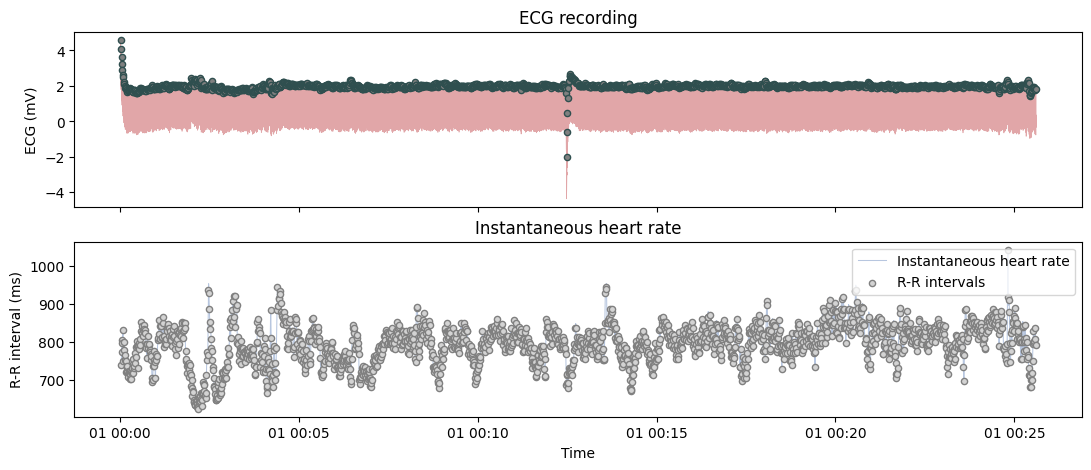

In [2]:
# Import PPG recording as pandas data frame
physio_df = import_dataset1(modalities=['ECG', 'Respiration'])

# Only use the first 60 seconds for demonstration
ecg = physio_df.ecg
plot_raw(ecg, modality='ecg', sfreq=1000, ecg_method='sleepecg', show_heart_rate=True)

In [3]:
# peaks detection using Pan-Tomkins
_, peaks = ecg_peaks(physio_df.ecg)

# convert the peaks vector into a RR time series
rr = input_conversion(x=peaks, input_type="peaks", output_type="rr_s")[:1400]
time = np.cumsum(rr)

### Model

In [4]:
hgf_logp_op = HGFDistribution(
    n_levels=2,
    model_type="continuous",
    input_data=[rr],
    time=[time]
)

In [5]:
with pm.Model() as three_level_hgf:

    # omegas priors
    omega_1 = pm.Uniform("omega_1", -20.0, -2.0)
    omega_2 = pm.Uniform("omega_2", -15.0, -2.0)

    pm.Potential(
        "hgf_loglike",
        hgf_logp_op(
            omega_1=omega_1,
            omega_2=omega_2,
            omega_input=np.log(1e-4),
            rho_1=0.0,
            rho_2=0.0,
            pi_1=1e4,
            pi_2=1e1,
            mu_1=rr[0],
            mu_2=0.0,
            kappa_1=1.0,
            omega_3=np.nan,
            rho_3=np.nan,
            pi_3=np.nan,
            mu_3=np.nan,
            kappa_2=np.nan
        ),
    )

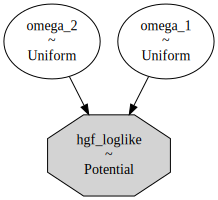

In [6]:
pm.model_to_graphviz(three_level_hgf)

In [7]:
with three_level_hgf:
    idata = pm.sample(chains=4, cores=4, tune=1000)

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


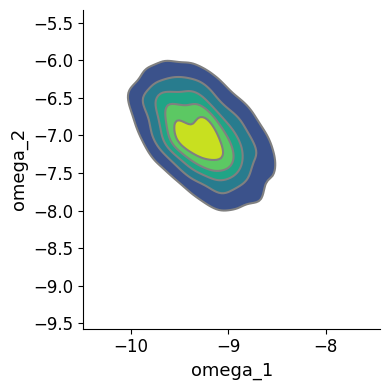

In [8]:
az.plot_pair(idata, kind="kde", figsize=(4, 4), textsize=12);
sns.despine()
plt.tight_layout()

In [9]:
hgf = HGF(
    n_levels=2,
    model_type="continuous",
    initial_mu={"1": rr[0], "2": 0.0},
    initial_pi={"1": 1e4, "2": 1e1},
    omega={
        "1": az.summary(idata)["mean"]["omega_1"], 
        "2": az.summary(idata)["mean"]["omega_2"], 
    },
    rho={"1": 0.0, "2": 0.0},
    kappas={"1": 1.0}).input_data(input_data=rr, time=time)

Creating a continuous Hierarchical Gaussian Filter with 2 levels.
Add 1400 new continuous observations.


array([<AxesSubplot: ylabel='$\\mu_2$'>, <AxesSubplot: ylabel='$\\mu_1$'>,
       <AxesSubplot: xlabel='Time', ylabel='Surprise'>], dtype=object)

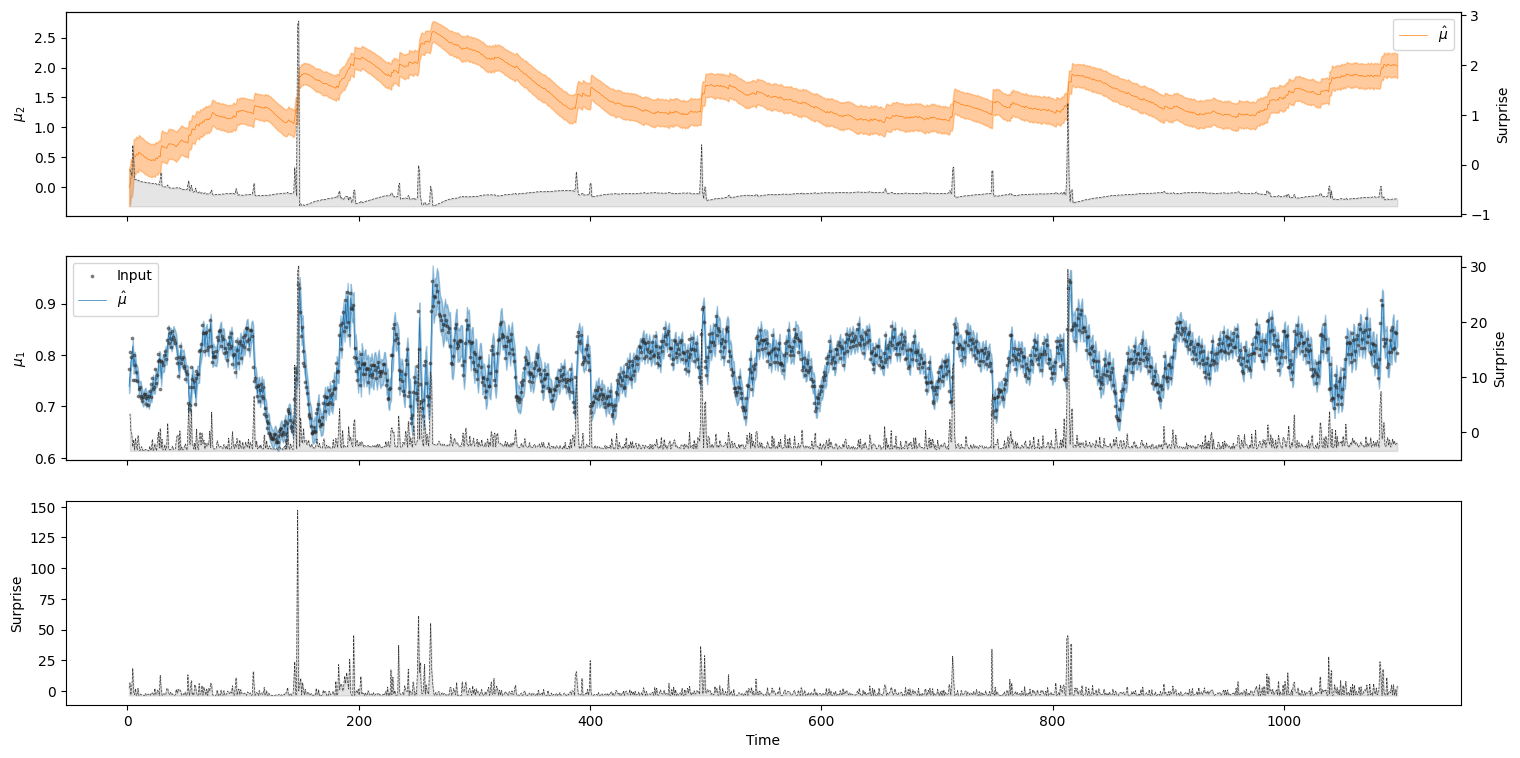

In [10]:
hgf.plot_trajectories()

# System configuration

In [11]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pyhgf,jax,jaxlib

Last updated: Tue Feb 21 2023

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 8.4.0

pyhgf : 0.0.1
jax   : 0.4.1
jaxlib: 0.4.1

arviz     : 0.13.0
numpy     : 1.19.0
pymc      : 5.0.2
matplotlib: 3.4.3
seaborn   : 0.12.1

Watermark: 2.3.1

